In [ ]:
# Install HuggingFace Transformers and Datasets
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
# Install scikit-learn for evaluation metrics
!pip install scikit-learn

In [ ]:
# AraBERT uses a custom Arabic preprocessor
!pip install arabert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 13.7 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=8aa48f4d0b8c1d89ce936c9437f64ea149115b1e316b32263e8825605d0aa8ed
  Stored in directory: /root/.cache/pip/wheels/94/08/b4/78657b1541bb704b088317b52429ee4016d9888fe47dbb130f
Successfully built emoji


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [ ]:
# Set Device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
# Load Dataset 
file_path = "/content/drive/MyDrive/Vectorization_Final.xlsx"
df = pd.read_excel(file_path, engine="openpyxl")

In [ ]:
# Split into labeled and unlabeled based on 'label' column
labeled_df = df[df['label'].notna()].copy()
unlabeled_df = df[df['label'].isna()].copy()

texts = labeled_df["normalization + translated"].astype(str).tolist()
labels = labeled_df["label"].astype(int).tolist()
unlabeled_texts = unlabeled_df["normalization + translated"].astype(str).tolist()

In [ ]:
# Split Labeled Data for Accuracy Check 
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [ ]:
# Tokenizer & Model 
model_name = "aubmindlab/bert-base-arabertv02"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def tokenize(texts):
    return tokenizer(texts, truncation=True, padding=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels
})

val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": val_labels
})

In [ ]:
# Model and Trainer 
num_labels = len(set(labels))
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training Setup 
training_args = TrainingArguments(
    output_dir="./arabert_initial_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Train the Model 
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: seniorprojectbtsa (seniorprojectbtsa-imam-abdulrahman-bin-faisal-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.336600,0.377678,0.865672
2,0.238200,0.364765,0.860697
3,0.109300,0.330556,0.895522


TrainOutput(global_step=153, training_loss=0.3202749153757407, metrics={'train_runtime': 104.0489, 'train_samples_per_second': 23.181, 'train_steps_per_second': 1.47, 'total_flos': 158657390889984.0, 'train_loss': 0.3202749153757407, 'epoch': 3.0})

In [ ]:
# Evaluate on Validation Set 
val_preds = trainer.predict(val_dataset)
val_predictions = np.argmax(val_preds.predictions, axis=1)

In [ ]:
print("\nInitial Training Accuracy:", accuracy_score(val_labels, val_predictions))
print("\nClassification Report:\n", classification_report(val_labels, val_predictions))
print("\nConfusion Matrix:\n", confusion_matrix(val_labels, val_predictions))


Initial Training Accuracy: 0.8955223880597015

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.89      0.67         9
           1       0.77      0.38      0.51        26
           2       0.94      0.98      0.96       166

    accuracy                           0.90       201
   macro avg       0.75      0.75      0.71       201
weighted avg       0.90      0.90      0.89       201


Confusion Matrix:
 [[  8   1   0]
 [  5  10  11]
 [  2   2 162]]


In [ ]:
# Predict on Unlabeled Data 
unlabeled_encodings = tokenize(unlabeled_texts)
unlabeled_dataset = Dataset.from_dict({
    "input_ids": unlabeled_encodings["input_ids"],
    "attention_mask": unlabeled_encodings["attention_mask"]
})

raw_preds = trainer.predict(unlabeled_dataset)
predicted_labels = np.argmax(raw_preds.predictions, axis=1)

In [ ]:
# Save Predictions into Original DataFrame 
df.loc[df['label'].isna(), 'predicted_label'] = predicted_labels

In [ ]:
df.to_excel("/content/drive/MyDrive/AraBERT_GPU_Results.xlsx", index=False)
print("Saved predictions to 'AraBERT_GPU_Results.xlsx'")

Saved predictions to 'AraBERT_GPU_Results.xlsx'


In [ ]:
# Save Model 
trainer.save_model("/content/drive/MyDrive/arabert_GPU_initial_model")
tokenizer.save_pretrained("/content/drive/MyDrive/arabert_GPU_initial_model")
print("Initial model saved in folder 'arabert_GPU_initial_model'")

Initial model saved in folder 'arabert_GPU_initial_model'


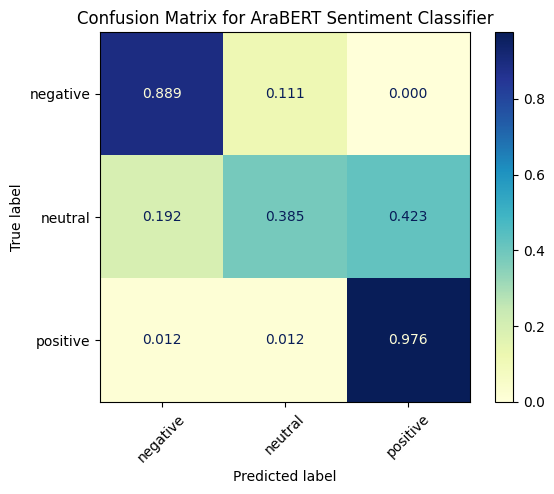

In [ ]:
# Normalized Confusion Matrix Plot 
cm = confusion_matrix(val_labels, val_predictions, normalize='true')
labels_list = ["negative", "neutral", "positive"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_list)
disp.plot(cmap="YlGnBu", values_format=".3f", xticks_rotation=45)
plt.title("Confusion Matrix for AraBERT Sentiment Classifier")
plt.savefig("/content/drive/MyDrive/Images/Confusion Matrix for AraBERT Sentiment Classifier.png")
plt.show()